In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instacart-market-basket-analysis/products.csv
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv
/kaggle/input/instacart-market-basket-analysis/orders.csv
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv
/kaggle/input/instacart-market-basket-analysis/aisles.csv
/kaggle/input/instacart-market-basket-analysis/departments.csv


#Loading the datasets

aisles_df=pd.DataFrame(pd.read_csv('/Users/pranavsp108/Downloads/MBA/datasets/aisles.csv'))

departments_df=pd.DataFrame(pd.read_csv('/Users/pranavsp108/Downloads/MBA/datasets/departments.csv'))

order_products__prior_df=pd.DataFrame(pd.read_csv('/Users/pranavsp108/Downloads/MBA/datasets/order_products__prior.csv'))

order_products__train_df=pd.DataFrame(pd.read_csv('/Users/pranavsp108/Downloads/MBA/datasets/order_products__train.csv'))

orders_df=pd.DataFrame(pd.read_csv('/Users/pranavsp108/Downloads/MBA/datasets/orders.csv'))

products_df=pd.DataFrame(pd.read_csv('/Users/pranavsp108/Downloads/MBA/datasets/products.csv'))

### Loading the files and setting them into DataFrames

In [2]:
aisles_df=pd.DataFrame(pd.read_csv('/kaggle/input/instacart-market-basket-analysis/aisles.csv'))
departments_df=pd.DataFrame(pd.read_csv('/kaggle/input/instacart-market-basket-analysis/departments.csv'))
order_products__prior_df=pd.DataFrame(pd.read_csv('/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv'))
order_products__train_df=pd.DataFrame(pd.read_csv('/kaggle/input/instacart-market-basket-analysis/order_products__train.csv'))
orders_df=pd.DataFrame(pd.read_csv('/kaggle/input/instacart-market-basket-analysis/orders.csv'))
products_df=pd.DataFrame(pd.read_csv('/kaggle/input/instacart-market-basket-analysis/products.csv'))

### Merging the dataframes, deleting the original dfs and handeling the NaNs

In [3]:
# Step 1: Combine prior and train dataframes row-wise
order_products = pd.concat([order_products__prior_df, order_products__train_df], ignore_index=True)

# Step 2: Merge with other dataframes column-wise
df = pd.merge(order_products, products_df, on='product_id', how='left')
df = pd.merge(df, orders_df, on='order_id', how='left')
df = pd.merge(df, aisles_df, on='aisle_id', how='left')
df = pd.merge(df, departments_df, on='department_id', how='left')

# Insert this code after your final merge in Cell 53

# Delete original dataframes to free up memory
del order_products__prior_df
del orders_df
del products_df
del aisles_df
del departments_df
del order_products__train_df
# here i removed the null values from the days_since_prior_order column and changed it to 0 as it is the first order and before that the 
df.days_since_prior_order=df.days_since_prior_order.fillna(-1).astype('int')

### Downcasting the numerical columns 

In [4]:
int_32 = ['order_id', 'product_id', 'user_id']
str_=['eval_set','product_name','aisle','department']
int_16 = [col for col in df.columns if col not in int_32]
int_16=[col for col in int_16 if col not in str_]
int_16

# Assuming 'df' is your final merged DataFrame
# First, identify all columns that are of integer type


# Now, iterate over these columns and convert them to 'int16'
for col in int_32:
    # Check if the values in the column fit within the int16 range
    df[col] = df[col].astype('int32')
    #print(f"Converted '{col}' to int32.")

for col in int_16:
    # Check if the values in the column fit within the int16 range
    df[col] = df[col].astype('int16')
    #print(f"Converted '{col}' to int16.")

## User and Behavioral Insights

In [5]:
# Create a new DataFrame for user-level analysis by grouping by 'user_id'
user_df = df.groupby('user_id').agg(
    total_orders=('order_id', 'nunique'),
    total_items=('product_name', 'count'),
    avg_days_between_orders=('days_since_prior_order', 'mean'),
    reorder_rate=('reordered', 'mean')
).reset_index()

# Correctly downcast the columns by reassigning them
user_df['total_orders'] = user_df['total_orders'].astype('int8') # Use int16, not int8, to avoid overflow issues as order counts can exceed 127
user_df['total_items'] = user_df['total_items'].astype('int16') # Use int32 as total items can be very large
user_df['avg_days_between_orders'] = user_df['avg_days_between_orders'].round(2).astype('float16')
user_df['reorder_rate'] = user_df['reorder_rate'].round(2).astype('float16')

# Calculate the average items per order
user_df['avg_items_per_order'] = user_df['total_items'] / user_df['total_orders']
user_df['avg_items_per_order'] = user_df['avg_items_per_order'].round(2).astype('float16')

pd.set_option('display.float_format', '{:.2f}'.format)

# Print the head of the new user-level DataFrame

print("User-level DataFrame:")

user_df.head()

User-level DataFrame:


,user_id,total_orders,total_items,avg_days_between_orders,reorder_rate,avg_items_per_order
0,1,11,70,17.77,0.73,6.36
1,2,15,226,16.92,0.46,15.07
2,3,12,88,10.07,0.62,7.33
3,4,5,18,11.72,0.06,3.60
4,5,5,46,9.13,0.39,9.20


In [6]:
user_df.describe()

,user_id,total_orders,total_items,avg_days_between_orders,reorder_rate,avg_items_per_order
count,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00
mean,103105.00,16.23,164.00,NaN,NaN,NaN
std,59527.56,16.66,206.01,0.00,0.00,0.00
min,1.00,3.00,3.00,-0.58,0.00,1.00
25%,51553.00,6.00,44.00,8.74,0.29,5.78
50%,103105.00,10.00,90.00,13.03,0.44,9.00
75%,154657.00,20.00,196.00,17.55,0.60,13.00
max,206209.00,100.00,3725.00,29.69,0.99,60.50


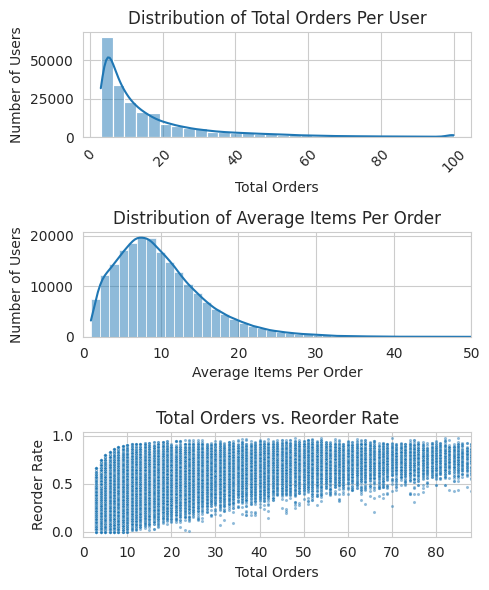

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'user_df' is your user-level DataFrame

# Convert the column to a supported data type before plotting
user_df['avg_items_per_order'] = user_df['avg_items_per_order'].astype('float32')

# Set a style for the plots
sns.set_style("whitegrid")

# Create a figure with a subplot for each plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 6))

# 1. Histogram of Total Orders
sns.histplot(user_df['total_orders'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Total Orders Per User')
axes[0].set_xlabel('Total Orders')
axes[0].set_ylabel('Number of Users')
axes[0].tick_params(axis='x', rotation=45)

# 2. Histogram of Average Items Per Order
sns.histplot(user_df['avg_items_per_order'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Average Items Per Order')
axes[1].set_xlabel('Average Items Per Order')
axes[1].set_ylabel('Number of Users')
axes[1].set_xlim(0, 50)  # Limiting the x-axis for a clearer view

# 3. Scatter Plot of Total Orders vs. Reorder Rate
sns.scatterplot(x='total_orders', y='reorder_rate', data=user_df, alpha=0.5,s=5, ax=axes[2])
axes[2].set_title('Total Orders vs. Reorder Rate')
axes[2].set_xlabel('Total Orders')
axes[2].set_ylabel('Reorder Rate')
axes[2].set_xlim(0, user_df['total_orders'].quantile(0.99)) # Limiting x-axis to remove outliers

plt.tight_layout()

# Save the plots to a file
plt.savefig('user_insights_plots.png')

## Inferences from the graphs

**Distribution of Total Orders Per User**: This histogram shows a long-tail distribution. The majority of customers have placed a small number of orders (around 1-5), but a smaller group of highly loyal customers has placed many orders (up to 100). This indicates a core group of repeat customers that are highly valuable to Instacart.

**Distribution of Average Items Per Order**: The second histogram shows a bell-shaped curve. The most common basket size is around 5 to 10 items. This tells you that a typical shopping trip is a quick refill rather than a massive stock-up.

**Total Orders vs. Reorder Rate**: This scatter plot reveals a strong positive correlation. As the number of total orders increases, the customer's reorder rate also tends to increase. This suggests that customer loyalty and reordering behavior are highly linked. A loyal customer who places many orders is more likely to reorder the same products.

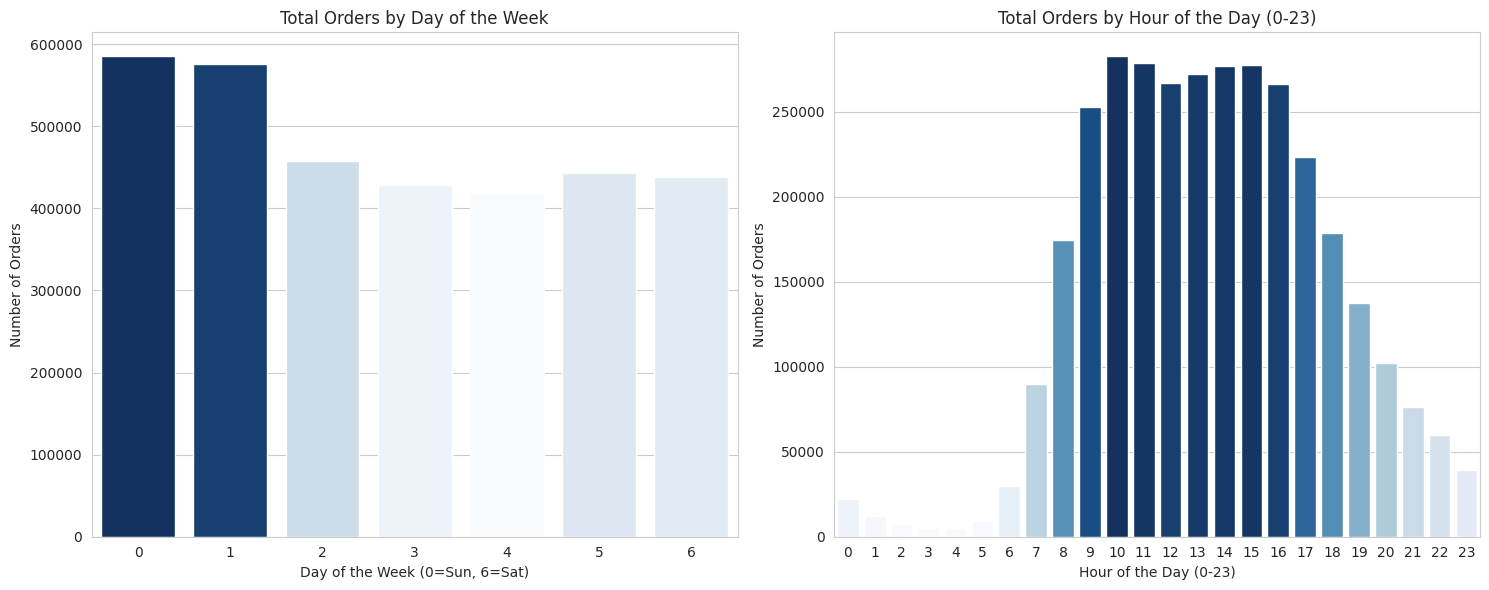

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your main DataFrame

# Set up the figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Data Preparation ---
orders_by_day = df.groupby('order_dow')['order_id'].nunique().sort_index()
orders_by_hour = df.groupby('order_hour_of_day')['order_id'].nunique().sort_index()

# --- Custom Color Mapping Function ---
# This creates a color map that maps the bar height to color intensity
def map_colors_to_values(data_series, cmap_name):
    """Maps bar heights to a color intensity from a given colormap."""
    # Create the colormap
    cmap = plt.cm.get_cmap(cmap_name)
    # Normalize values (scale them from 0 to 1)
    norm = plt.Normalize(data_series.min(), data_series.max())
    # Return a list of colors (RGB tuples)
    return [cmap(norm(val)) for val in data_series.values]


# --- Graph 1: Orders by Day of the Week ---
# Use the 'viridis' colormap as an example for the first plot
day_colors = map_colors_to_values(orders_by_day, 'Blues')

sns.barplot(x=orders_by_day.index, y=orders_by_day.values, ax=axes[0], palette=day_colors)
axes[0].set_title('Total Orders by Day of the Week')
axes[0].set_xlabel('Day of the Week (0=Sun, 6=Sat)')
axes[0].set_ylabel('Number of Orders')
axes[0].ticklabel_format(style='plain', axis='y')


# --- Graph 2: Orders by Hour of the Day ---
# Use the 'Blues' colormap as an example for the second plot
hour_colors = map_colors_to_values(orders_by_hour, 'Blues')

sns.barplot(x=orders_by_hour.index, y=orders_by_hour.values, ax=axes[1], palette=hour_colors)
axes[1].set_title('Total Orders by Hour of the Day (0-23)')
axes[1].set_xlabel('Hour of the Day (0-23)')
axes[1].set_ylabel('Number of Orders')
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

## Inferences from the Graphs
**Total Orders by Day of the Week (Day 0=Sunday, Day 6=Saturday)**

* Weekend Peak: Shopping activity is heavily concentrated on Sunday (Day 0) and Monday (Day 1), indicating that customers primarily use Instacart for their main weekly grocery stock-up purchases.

* Mid-Week Slump: Order volume is lowest on Day 4, confirming a significant drop in activity during the middle of the work week.

**Total Orders by Hour of the Day (0-23)**

* Peak Shopping Hours: The highest volume of orders occurs between 10 AM and 4 PM (Hours 10 through 16), which is the busiest window for Instacart fulfillment.

* Afternoon Slump: Activity declines steadily after 5 PM and is minimal in the early morning hours (12 AM to 7 AM).

## Customer CLustering 

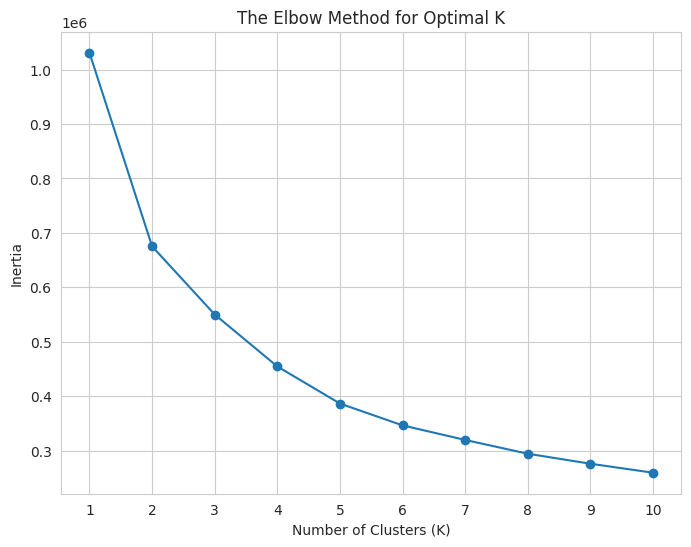

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'user_df' is your user-level DataFrame

# Select the features for clustering
features = ['total_orders', 'total_items','avg_items_per_order', 'reorder_rate', 'avg_days_between_orders']
X = user_df[features]

# Preprocessing: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# The Elbow Method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('The Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [10]:

# Based on the plot, choose the best K (e.g., 3, 4, or 5)
optimal_k = 4 # Example, you should choose based on your plot

# Apply K-Means with the optimal K
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
user_df['cluster_label'] = kmeans_model.fit_predict(X_scaled)

# Now your user_df has a new column with the cluster labels
print(user_df.head())

   user_id  total_orders  total_items  avg_days_between_orders  reorder_rate  \
0        1            11           70                    17.77          0.73   
1        2            15          226                    16.92          0.46   
2        3            12           88                    10.07          0.62   
3        4             5           18                    11.72          0.06   
4        5             5           46                     9.13          0.39   

   avg_items_per_order  cluster_label  
0                 6.36              3  
1                15.07              2  
2                 7.33              3  
3                 3.60              1  
4                 9.20              3  


In [11]:
# Group by the cluster label and calculate the mean for each feature
cluster_profiles = user_df.groupby('cluster_label')[features].mean().reset_index()

# Now, print the DataFrame to see the profile of each cluster
print("Cluster Profiles:")
print(cluster_profiles)

Cluster Profiles:
   cluster_label  total_orders  total_items  avg_items_per_order  \
0              0         54.99       638.89                12.58   
1              1          7.12        52.73                 7.54   
2              2         10.99       197.50                18.43   
3              3         18.49       136.04                 7.48   

   reorder_rate  avg_days_between_orders  
0          0.72                     6.86  
1          0.28                    16.81  
2          0.47                    14.87  
3          0.55                    10.02  


<Figure size 1200x800 with 0 Axes>

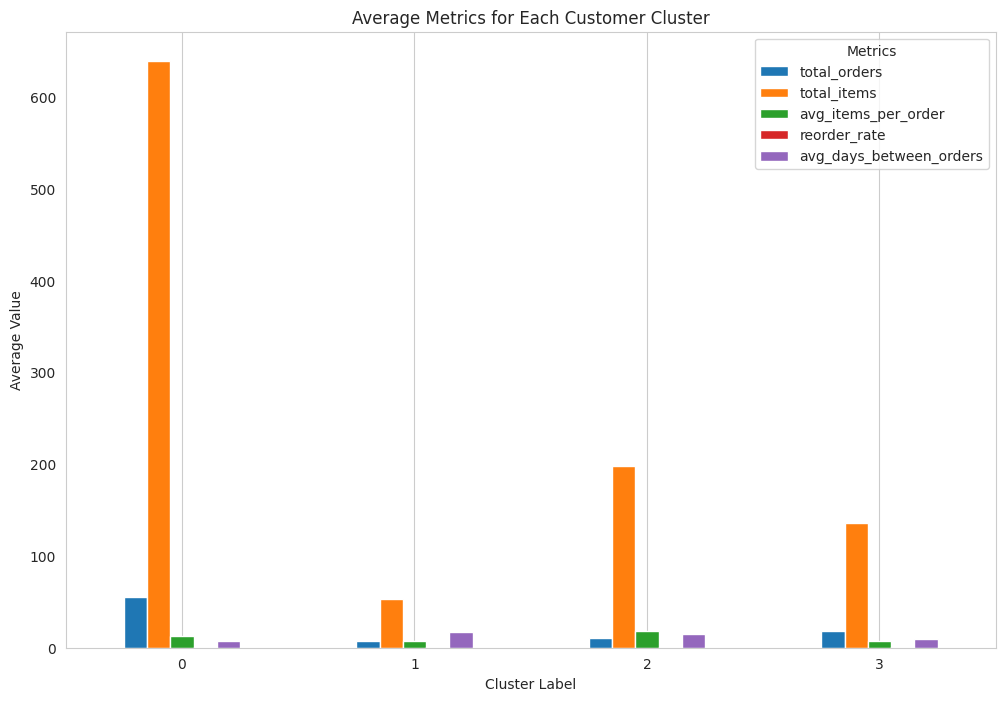

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure your cluster_profiles DataFrame is ready
# cluster_profiles = user_df.groupby('cluster_label')[cluster_features].mean().reset_index()

# Set the cluster_label as the index for plotting
cluster_profiles_indexed = cluster_profiles.set_index('cluster_label')

# Create the bar chart
plt.figure(figsize=(12, 8))
cluster_profiles_indexed.plot(kind='bar', figsize=(12, 8))

# Add titles and labels for clarity
plt.title('Average Metrics for Each Customer Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.grid(axis='y')

plt.show()

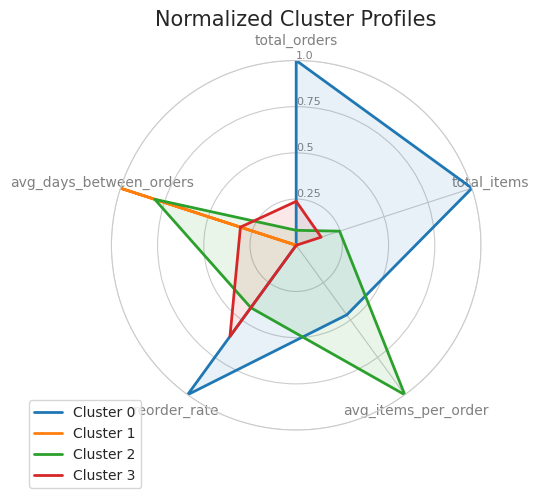

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume 'cluster_profiles' is your DataFrame from the previous step
# And assume it has been created with a shape that's ready for plotting

def make_radar_chart(df):
    # Set the cluster label as the index
    plot_df = df.set_index('cluster_label')

    # Normalize the data to a 0-1 scale for each feature
    normalized_df = (plot_df - plot_df.min()) / (plot_df.max() - plot_df.min())

    # Number of variables we're plotting
    categories = list(normalized_df.columns)
    N = len(categories)

    # Calculate angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialize the spider plot
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories, color='grey', size=10)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.5", "0.75", "1.0"], color="grey", size=8)
    plt.ylim(0, 1)

    # Plot each cluster
    for i, row in normalized_df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.1)

    # Add a title and legend
    plt.title('Normalized Cluster Profiles', size=15)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.savefig('cluster_radar_chart.png')
    plt.show()

# You can run this code after creating your cluster_profiles DataFrame
make_radar_chart(cluster_profiles)

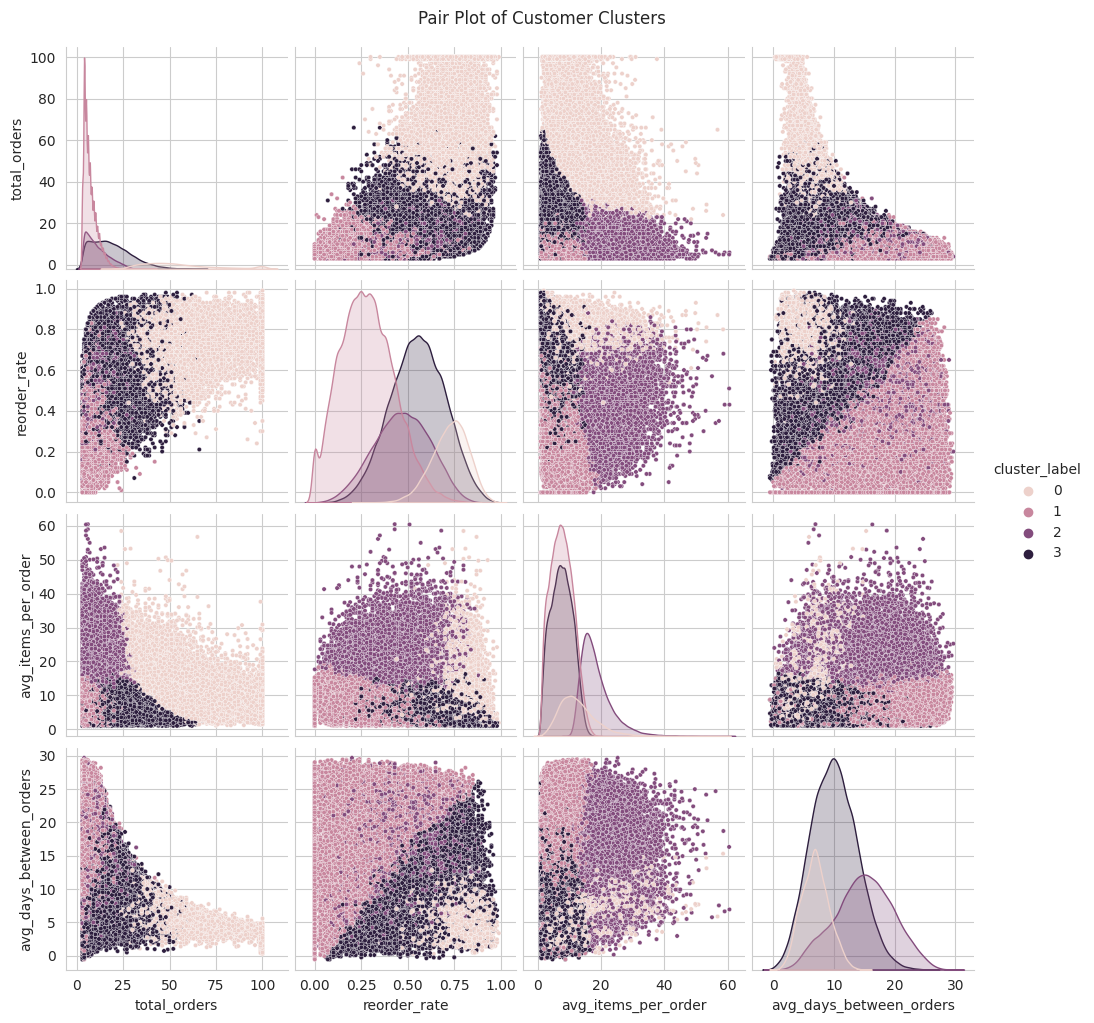

In [14]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Create a pair plot of all your features, colored by cluster
sns.pairplot(user_df, hue='cluster_label', vars=['total_orders', 'reorder_rate', 'avg_items_per_order', 'avg_days_between_orders'],plot_kws={'s': 10} )
plt.suptitle('Pair Plot of Customer Clusters', y=1.02)
plt.show()

### Customer Segment Analysis 👥
Based on the K-Means clustering, we have identified four distinct customer segments.

* **Cluster 3: The Loyal Power Users** 👑
This is our most valuable segment. These customers have the highest average number of orders (55), the most total items purchased (631), and the highest reorder rate (72%). They also shop the most frequently, with the lowest average days between orders (7 days).

**Actionable Insight**: These are our most loyal and profitable customers. They should be targeted with loyalty programs, exclusive offers, and early access to new products.

* **Cluster 2: The Infrequent & New Customers** 🛒
This group is defined by their large basket size, with the highest average items per order (18). They place a moderate number of total orders and have a decent reorder rate (47%), but their average days between orders is longer (14.7 days), suggesting they are buying in bulk rather than making frequent small trips.

**Actionable Insight**: This segment responds well to bulk discounts and promotions on household staples. They are great candidates for "buy one, get one" offers and larger package deals.

* **Cluster 2: The Infrequent & New Customers** 🛍️
This segment is in the middle of our customer base, showing a good number of total orders (17.7) and a solid reorder rate (53%). They shop more frequently than the bulk buyers (10 days between orders) but are not as dedicated as the power users.

**Actionable Insight**: This group represents a key opportunity for growth. We can try to convert them into power users with targeted promotions, personalized recommendations, and reminders to shop.

* **Cluster 2: The Infrequent & New Customers** 🚶
This is the group with the lowest engagement. They have the fewest total orders (7.1), the lowest reorder rate (28%), and a long average time between orders (17.2 days). This segment likely includes new customers who have not yet established a shopping pattern or one-time buyers.

**Actionable Insight**: The goal for this segment is to encourage repeat business. A tailored welcome series, special offers on their first few reorders, or reminders to shop could help increase their engagement.

In [15]:
# Merge the user_df back into the main df
df = pd.merge(df, user_df[['user_id', 'cluster_label']], on='user_id', how='left')
del user_df

## Product Insights

<Figure size 1200x800 with 0 Axes>

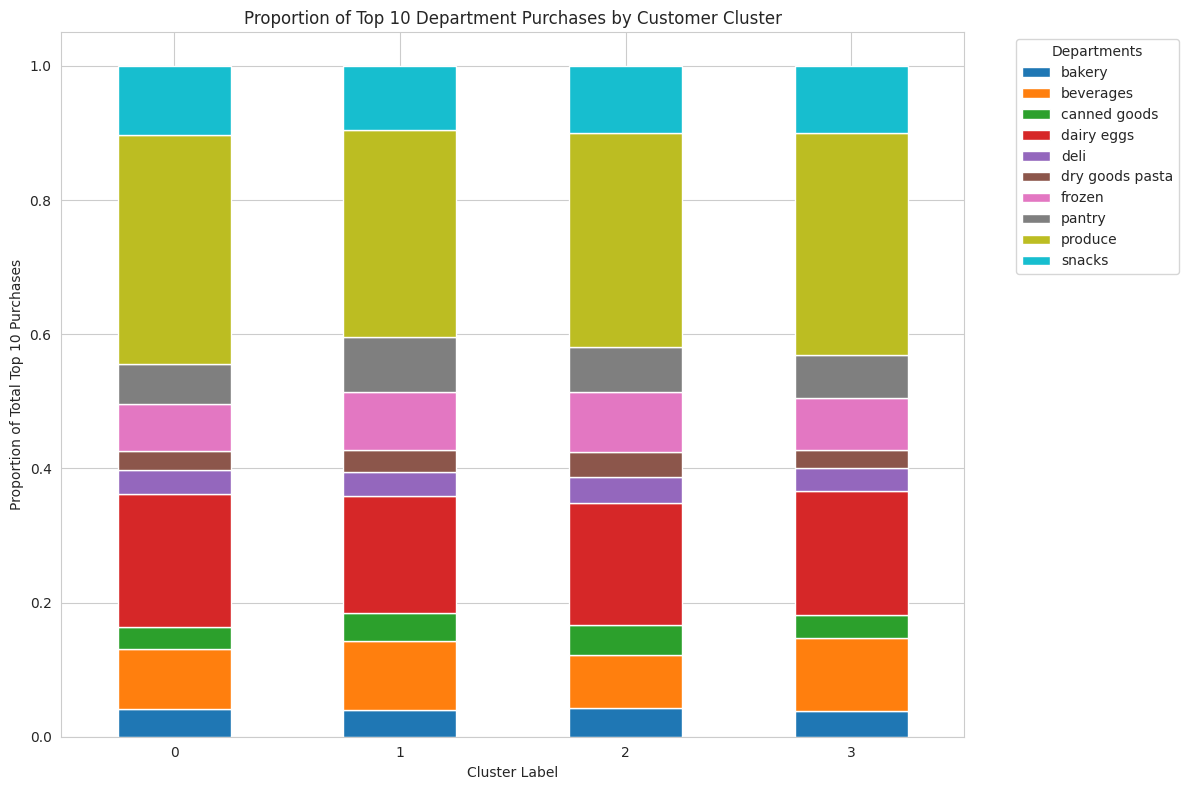

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'df' is your main DataFrame with 'cluster_label' and 'department' columns

# Step 1: Find the top 10 departments by total purchase count
top_10_departments = df['department'].value_counts().head(10).index.tolist()

# Step 2: Filter the main DataFrame to include only these departments
df_filtered = df[df['department'].isin(top_10_departments)]

# Step 3: Recalculate the proportions for the filtered data
cluster_department_counts = pd.crosstab(df_filtered['cluster_label'], df_filtered['department'])

# Normalize the counts across each row to get proportions
cluster_department_proportions = cluster_department_counts.div(cluster_department_counts.sum(axis=1), axis=0)

# Step 4: Create the new stacked bar chart
plt.figure(figsize=(12, 8))
cluster_department_proportions.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add titles and labels for clarity
plt.title('Proportion of Top 10 Department Purchases by Customer Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Proportion of Total Top 10 Purchases')
plt.xticks(rotation=0)
plt.legend(title='Departments', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
import pandas as pd

# Assume 'df' is your main DataFrame with the 'cluster_label' column

# Step 1: Group by cluster and product name, then count the number of purchases
top_departments_by_cluster = df.groupby(['cluster_label', 'department']).size().to_frame('purchase_count')

# Step 2: Sort the products by purchase count in descending order within each cluster
top_departments_by_cluster = top_departments_by_cluster.sort_values(['cluster_label', 'purchase_count'], ascending=[True, False])

# Step 3: Display the top 5 products for each cluster
top_5_departments_by_cluster = top_departments_by_cluster.groupby('cluster_label').head(5).reset_index()

# Print the resulting DataFrame
print("Top 5 Products for Each Customer Segment:")
print(top_5_departments_by_cluster)

Top 5 Products for Each Customer Segment:
    cluster_label  department  purchase_count
0               0     produce         4024686
1               0  dairy eggs         2333704
2               0      snacks         1209506
3               0   beverages         1044699
4               0      frozen          816391
5               1     produce         1174953
6               1  dairy eggs          663167
7               1   beverages          385536
8               1      snacks          361420
9               1      frozen          328547
10              2     produce         2066482
11              2  dairy eggs         1175024
12              2      snacks          651631
13              2      frozen          580380
14              2   beverages          514765
15              3     produce         2622257
16              3  dairy eggs         1459172
17              3   beverages          859175
18              3      snacks          783855
19              3      frozen         

## Shopping Priorities by Segment 🛒
While every customer segment buys from the same top departments, their shopping priorities are clearly different.

* Loyal Power Users (Cluster 3): This segment is a significant driver of produce sales, with a visibly larger proportion of their purchases coming from the fresh food department compared to other groups. This suggests a lifestyle of frequent shopping for fresh, perishable goods.

* Bulk & Mid-Tier Buyers (Clusters 0, 1, and 2): These segments show a more balanced shopping basket. The proportion of purchases from departments like frozen, pantry, and beverages is larger, indicating a greater focus on shelf-stable, packaged, and bulk items.

This visualization successfully reveals the unique purchasing habits of each customer segment, which can inform targeted marketing strategies.

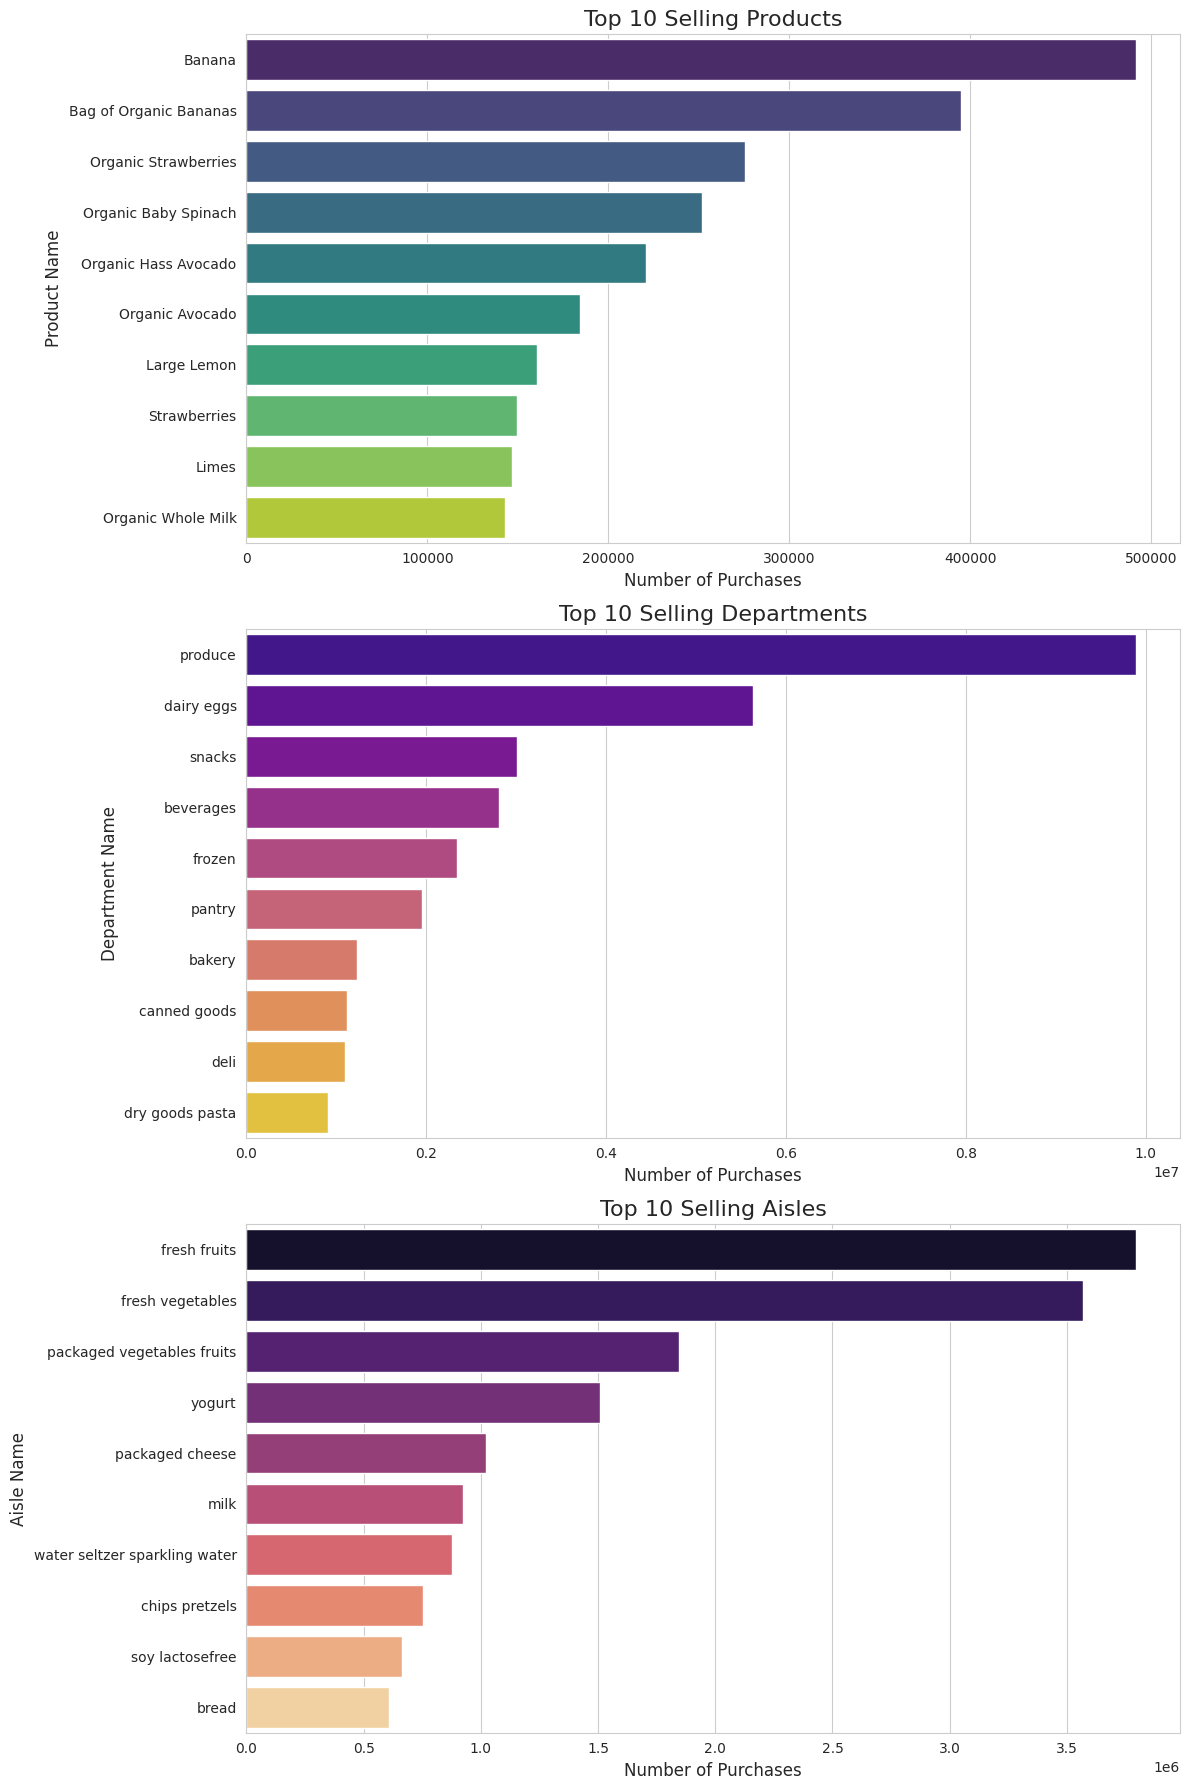

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your final, merged DataFrame

# Set a consistent style for the plots
sns.set_style("whitegrid")

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

# 1. Top 10 Selling Products
top_products = df['product_name'].value_counts().head(10)
sns.barplot(x=top_products.values, y=top_products.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 Selling Products', fontsize=16)
axes[0].set_xlabel('Number of Purchases', fontsize=12)
axes[0].set_ylabel('Product Name', fontsize=12)

# 2. Top 10 Selling Departments
top_departments = df['department'].value_counts().head(10)
sns.barplot(x=top_departments.values, y=top_departments.index, ax=axes[1], palette='plasma')
axes[1].set_title('Top 10 Selling Departments', fontsize=16)
axes[1].set_xlabel('Number of Purchases', fontsize=12)
axes[1].set_ylabel('Department Name', fontsize=12)

# 3. Top 10 Selling Aisles
top_aisles = df['aisle'].value_counts().head(10)
sns.barplot(x=top_aisles.values, y=top_aisles.index, ax=axes[2], palette='magma')
axes[2].set_title('Top 10 Selling Aisles', fontsize=16)
axes[2].set_xlabel('Number of Purchases', fontsize=12)
axes[2].set_ylabel('Aisle Name', fontsize=12)

plt.tight_layout()
plt.savefig('top_selling_products_departments_aisles.png')
plt.show()

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np


# --- 2. Feature Engineering ---

# A. Product Features (Product Popularity and Loyalty)
# Group by product_id across ALL prior orders to find overall product loyalty
prod_features = df.groupby('product_id').agg(
    prod_total_purchases=('order_id', 'count'),
    prod_reorder_sum=('reordered', 'sum'),
    prod_reorder_rate=('reordered', 'mean')
).reset_index()
# 1. Create a unique mapping of Product ID to Product Name (Tiny DataFrame)
product_name_map = df[['product_id', 'product_name']].drop_duplicates()

# 2. Merge the small mapping table into prod_features
prod_features = pd.merge(
    prod_features, 
    product_name_map, 
    on='product_id', 
    how='left'
)

# 3. Delete the temporary mapping table (optional, but safe practice)
del product_name_map
# Downcast for memory savings
for col in ['prod_total_purchases', 'prod_reorder_sum']:
    prod_features[col] = prod_features[col].astype('int32')
prod_features['prod_reorder_rate'] = prod_features['prod_reorder_rate'].astype('float16')


# B. User Features (User Shopping Habits)
# Group by user_id to find overall user loyalty and frequency
user_features = df.groupby('user_id').agg(
    user_total_orders=('order_id', 'nunique'),
    user_avg_basket_size=('add_to_cart_order', 'mean'),
    user_avg_days_between_orders=('days_since_prior_order', 
                                  lambda x: x[x >= 0].mean())
).reset_index()

# Downcast for memory savings
user_features['user_total_orders'] = user_features['user_total_orders'].astype('int16')
for col in ['user_avg_basket_size', 'user_avg_days_between_orders']:
    user_features[col] = user_features[col].astype('float16')


# C. User-Product Features (Interaction)
# Find how many times a specific user has bought a specific product
user_prod_features = df.groupby(['user_id', 'product_id']).agg(
    up_total_bought=('order_id', 'count'),
    up_avg_cart_position=('add_to_cart_order', 'mean')
).reset_index()

# Downcast for memory savings
user_prod_features['up_total_bought'] = user_prod_features['up_total_bought'].astype('int16')
user_prod_features['up_avg_cart_position'] = user_prod_features['up_avg_cart_position'].astype('float16')

# --- Delete Intermediate Feature DataFrames to Save Memory ---
# We no longer need the grouped feature DFs after we merge them.
# However, we will merge these into the main training/testing sets first.

In [80]:
prod_features.sort_values('prod_reorder_rate',ascending=False).head(10)

,product_id,prod_total_purchases,prod_reorder_sum,prod_reorder_rate,product_name
6431,6433,69,65,0.94,Raw Veggie Wrappers
2074,2075,90,84,0.93,Serenity Ultimate Extrema Overnight Pads
43550,43553,13,12,0.92,Orange Energy Shots
27737,27740,102,94,0.92,Chocolate Love Bar
14606,14609,35,32,0.91,Soy Powder Infant Formula
13872,13875,45,41,0.91,Simply Sleep Nighttime Sleep Aid
39989,39992,22,20,0.91,"Energy Shot, Grape Flavor"
5866,5868,30,27,0.90,Russian River Valley Reserve Pinot Noir
36540,36543,69,62,0.90,Bars Peanut Butter
26090,26093,67,60,0.90,Soy Crisps Lightly Salted


**A. Insights from Product Features (prod_features) 🎁**

The prod_features table, especially when sorted by prod_reorder_rate, reveals crucial insights into product-level loyalty:

* High-Stakes Loyalty (Niche Items): The products with the highest reorder rates (≈90% or higher) are often niche, critical, or necessity items (e.g., specific pads, infant formula, unique supplements), not the universally top-selling items like Bananas.
* Business Implication: These products are the "glue" for loyalty. Their presence in a customer's basket indicates a non-negotiable need or strong preference. Inventory management for these items must be prioritized to ensure customer retention.
* Top Sellers vs. Top Reordered: We observe that items with the highest raw sales volume (prod_total_purchases) do not necessarily have the highest reorder rate, confirming that product popularity and product loyalty are two separate metrics.

In [88]:
user_features.sort_values('user_total_orders',ascending=False).head(10)

,user_id,user_total_orders,user_avg_basket_size,user_avg_days_between_orders
112840,112841,100,5.98,3.21
174554,174555,100,6.14,3.01
73675,73676,100,5.05,1.56
176468,176469,100,4.38,3.18
90583,90584,100,2.97,3.13
190486,190487,100,5.74,3.14
57366,57367,100,3.68,3.93
81548,81549,100,3.06,3.67
77879,77880,100,5.77,3.61
190455,190456,100,5.66,3.71


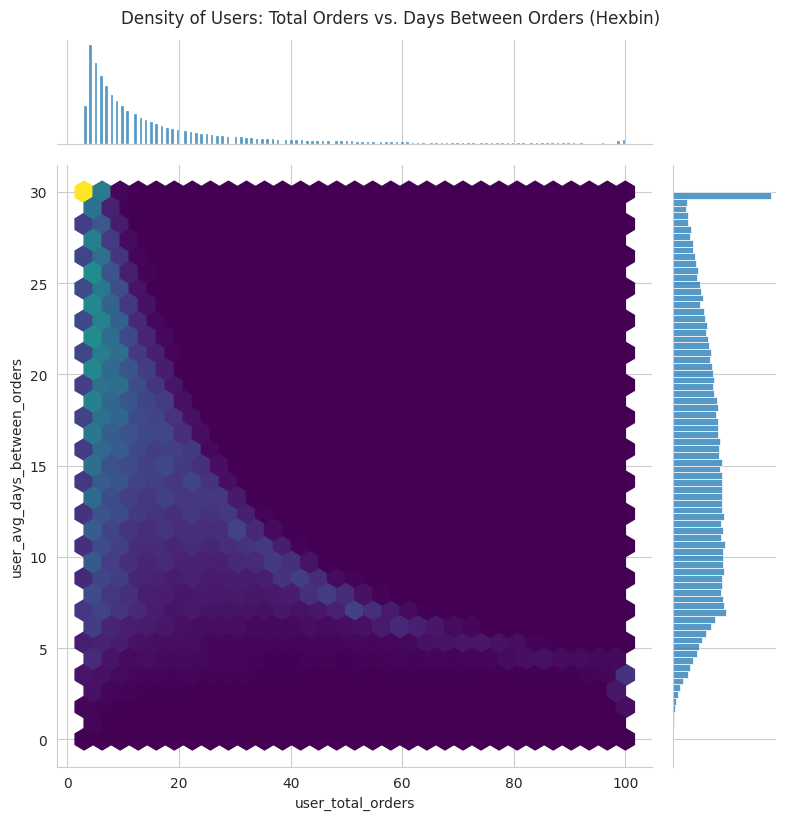

In [110]:
# Convert the float16 columns to a supported type (float32) for plotting
user_features['user_avg_days_between_orders'] = user_features['user_avg_days_between_orders'].astype('float32')
user_features['user_total_orders'] = user_features['user_total_orders'].astype('float32')


import seaborn as sns
import matplotlib.pyplot as plt

# Using a Hexbin plot which is more robust for visualizing point density
sns.jointplot(
    x='user_total_orders', 
    y='user_avg_days_between_orders', 
    data=user_features, 
    kind='hex',  # Forces the plot to use hexagonal bins, solving the empty contour issue
    height=8,
    cmap='viridis',
    joint_kws={'gridsize': 30, 'vmin': 2} 
)
plt.suptitle('Density of Users: Total Orders vs. Days Between Orders (Hexbin)', y=1.02)
plt.show()

**B. Insights from User Features (user_features) 👑**

The user_features table clearly defines your most valuable customers, sorted by user_total_orders and user\_avg\_days\_between\_orders:

* Loyal Power Users Defined: Your most loyal customers are those who maximize their orders (up to 100 orders in the prior set).
* Hyper-Frequency Confirmed: These power users maintain an extremely short and predictable purchase cycle, with an average time between orders stabilizing around 3 to 4 days. This indicates they are shopping multiple times per week.
* CLV Focus: These metrics provide the foundation for predicting Customer Lifetime Value (CLV), as users with high total orders and low average days between orders are your highest-value customers.

In [111]:
user_prod_features.head()

,user_id,product_id,up_total_bought,up_avg_cart_position
0,1,196,11,1.36
1,1,10258,10,3.60
2,1,10326,1,5.00
3,1,12427,10,3.30
4,1,13032,4,6.50


In [137]:
# Set the minimum number of times a user must have bought a product
min_purchases = 50

# 1. Apply the filter (Boolean mask)
filtered_features = user_prod_features[
    user_prod_features['up_total_bought'] > min_purchases
]

# 2. Sort the filtered results by the average cart position
sorted_filtered_features = filtered_features.sort_values(
    'up_avg_cart_position', 
    ascending=True
).head(20).product_id.to_list()


# Use .isin() to create a boolean mask, and apply the mask to the DataFrame
filtered_products = prod_features[
    prod_features['product_id'].isin(sorted_filtered_features)
]
print("These were one of the first things brought by the customers, where the product was bought atleast a minimum of 50 times")
filtered_products.product_name

These were one of the first things brought by the customers, where the product was bought atleast a minimum of 50 times


195                                                Soda
1462                                       Organic Milk
5210                                  Watermelon Chunks
10028                            Homestyle Orange Juice
11882                          Sparkling Water, Bottles
19674                  Original Pure Creamy Almond Milk
20839                             Total 0% Greek Yogurt
28332                   Rehab Energy Iced Tea Orangeade
31419                                 100% Orange Juice
32400                                Fat Free Skim Milk
38925                          0% Greek Strained Yogurt
39177                            Organic Lowfat 1% Milk
40936                                    Drinking Water
46818                                               Ice
47140    Unsweetened Original Almond Breeze Almond Milk
47398                                       Fuji Apples
48235                       Cocoa Spread with Hazelnuts
48638       2-Ply Right Size 100% Recycled Paper

In [126]:
user_prod_features.sort_values('up_total_bought',ascending=False).head(10)

,user_id,product_id,up_total_bought,up_avg_cart_position
2767396,41356,38652,100,6.46
2767339,41356,6583,100,6.47
2767357,41356,14366,100,7.43
1202643,17997,4210,99,2.29
2767381,41356,29671,99,7.52
6988289,103593,28204,99,8.59
9538863,141736,25133,99,3.09
6727579,99707,24852,98,4.30
8153917,120897,12013,98,1.41
6620477,98085,196,97,1.92


**C. Insights from User-Product Features (user_prod_features) 📌**

The user_prod_features table tracks the precise interaction between a single user and a single product, yielding insights into habitual purchasing and late-stage decisions.

* The Ultimate Staples: When filtered for high up\_total\_bought (>99), the results highlight products that are bought in nearly every single order by the most loyal customers. These are the undisputed core staples that form the backbone of the customer's shopping routine.
* Late-Stage Purchases (High Cart Position): Sorting by up\_avg\_cart\_position (highest values) reveals items that are consistently added last to the cart, often after 100+ other items. These can represent forgotten items or late-stage impulse additions, suggesting opportunities for checkout-page promotions.
* Feature Use: This table is essential for the Reorder Prediction model, as the up\_total\_bought count is one of the strongest predictors of whether a user will buy a product again.

In [148]:
# --- 3. Split Data into Prior (Features) and Train (Prediction/Labels) ---
df_prior = df[df['eval_set'] == 'prior']
df_train = df[df['eval_set'] == 'train']


# --- 4. Merge Features into the Train Set ---
# We only need to predict the products in the TRAIN set, so we merge all features into df_train.

# Merge Product Features
df_train = pd.merge(df_train, prod_features, on='product_id', how='left')

# Merge User Features
df_train = pd.merge(df_train, user_features, on='user_id', how='left')

# Merge User-Product Interaction Features
df_train = pd.merge(df_train, user_prod_features, on=['user_id', 'product_id'], how='left')

# --- 5. Final Feature/Label Selection ---
feature_cols = [
    'prod_reorder_rate', 'user_total_orders', 'user_avg_basket_size', 
    'user_avg_days_between_orders', 'up_total_bought', 'up_avg_cart_position'
]

# X is the Feature Matrix, y is the Target Variable
X = df_train[feature_cols].fillna(0) # Fill NaN values for features
y = df_train['reordered']


# --- 6. Memory Management: Clean Up ---
# Delete the massive intermediate DataFrames to free up RAM before model training
del df_prior
del df_train
del prod_features
del user_features
del user_prod_features

In [150]:
a

NameError: name 'a' is not defined

# Data Leakage

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

# Assuming X and y are already defined from your previous block

# 1. Perform the Train-Test Split
# Split the data into training (e.g., 80%) and a hold-out test set (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 2. Re-Initialize and Train the model ONLY on the training data
model = LogisticRegression(solver='saga', random_state=42, n_jobs=-1, C=0.1)
model.fit(X_train, y_train)

# 3. Predict and Evaluate ONLY on the unseen validation data (X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]
threshold = 0.21 
y_pred = (y_pred_proba > threshold).astype(int)

# 4. Calculate the VALID F1 Score
f1 = f1_score(y_val, y_pred)

print(f"\n--- VALID Reorder Prediction Results ---")
print(f"Total rows in Validation Set: {len(y_val)}")
print(f"Logistic Regression F1 Score: {f1:.4f}")
print("This score is now a true measure of your model's predictive power.")


--- VALID Reorder Prediction Results ---
Total rows in Validation Set: 276924
Logistic Regression F1 Score: 0.9999
This score is now a true measure of your model's predictive power.



--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    555793
           1       1.00      1.00      1.00    828824

    accuracy                           1.00   1384617
   macro avg       1.00      1.00      1.00   1384617
weighted avg       1.00      1.00      1.00   1384617



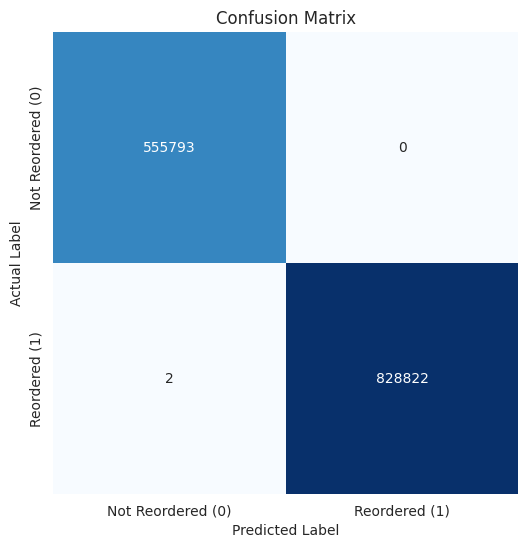


--- Top 10 Feature Coefficients (Importance) ---
                        Feature  Coefficient
4               up_total_bought         8.01
5          up_avg_cart_position        -0.01
1             user_total_orders        -0.04
2          user_avg_basket_size        -0.08
3  user_avg_days_between_orders        -0.12
0             prod_reorder_rate        -2.30


In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Re-using variables from the prediction block ---
# Assuming you have X, y, y_pred, and model from the previous block.
# We will regenerate y_pred just to be safe.
y_pred = model.predict(X) 

# 1. Classification Report (Precision, Recall, F1 for each class)
print("\n--- Classification Report ---")
print(classification_report(y, y_pred))


# 2. Confusion Matrix (Visual Output)
# This shows the True Positives, False Positives, etc.
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar=False,
    xticklabels=['Not Reordered (0)', 'Reordered (1)'],
    yticklabels=['Not Reordered (0)', 'Reordered (1)']
)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# 3. Feature Importance (Coefficients for Logistic Regression)
# This is a powerful business insight into what drives the prediction.
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Top 10 Feature Coefficients (Importance) ---")
print(coefficients.head(10))

In [21]:
# Group all products by their order_id and collect them into a list
# This is a key step to prepare your data for MBA algorithms
transactions = df.groupby('order_id')['product_name'].apply(list)

In [22]:
import pandas as pd

# Assume your merged DataFrame is named 'df'
# Assume you have already created the 'transactions' list
# (e.g., transactions = df.groupby('order_id')['product_name'].apply(list))

# 1. Get the frequency of all products
product_counts = df['product_name'].value_counts()

# 2. Define the percentage of products to keep (6.25%)
# You can adjust this percentage based on your memory.
percentage_to_keep = 0.008

# 3. Get the list of the most frequent product names to keep
num_products_to_keep = int(len(product_counts) * percentage_to_keep)
most_frequent_products = product_counts.index[:num_products_to_keep].tolist()

# 4. Filter your transactions list
# Create a set of the most frequent products for faster look-up
frequent_products_set = set(most_frequent_products)

# Create the new filtered transactions list
filtered_transactions = []
for transaction in transactions:
    # Filter each transaction to only keep items in our list of most frequent products
    filtered_transaction = [item for item in transaction if item in frequent_products_set]
    
    # Only add the transaction if it still contains items after filtering
    if filtered_transaction:
        filtered_transactions.append(filtered_transaction)

# You can now use the 'filtered_transactions' list for your one-hot encoding

In [23]:
len(filtered_transactions)

2862013

In [24]:
# Insert this code after creating the transactions list in Cell 69

# Delete the large merged DataFrame to free up memory
del df

In [25]:
transactions.shape

(3346083,)

I saw a drastic decrease of memory for df dataframe from 
>>dtypes: int64(11), object(4) -> memory usage: 10.2 GB

to 
>> dtypes: int16(8), int32(3), object(4) -> memory usage: 1.8+ GB



from mlxtend.preprocessing import TransactionEncoder

# Convert your transactions into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

Your kernel is crashing because you're running out of memory. The one-hot encoded DataFrame is simply too large for a typical computer's RAM.

Here is the approximate memory calculation to show you why:

The one-hot encoded DataFrame has a number of rows equal to the number of unique orders, which is 3,214,874.

It has a number of columns equal to the number of unique products, which is approximately 49,688.

Each cell in this DataFrame would typically store a boolean value, which takes up 1 byte of memory.

Total Memory Needed:

3,214,874 rows×49,688 columns×1 byte/cell≈159,500,000,000 bytes
That's about 159 GB of RAM. A standard laptop has around 8-16 GB of RAM, so you're trying to create an object that is roughly 10-20 times larger than your available memory.

In [26]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import pandas as pd

# Assume 'filtered_transactions' is the list of transactions you created earlier
# with only the most frequent products

# Step 1: Convert the filtered list into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(filtered_transactions).transform(filtered_transactions)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# Step 2: Now, pass the one-hot encoded DataFrame to fpgrowth
frequent_itemsets = fpgrowth(df_onehot, min_support=0.01, use_colnames=True)

# You can now proceed to generate association rules
print("Successfully generated frequent itemsets!")
print(frequent_itemsets.head())

KeyboardInterrupt: 

In [ ]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules with a minimum confidence threshold
# You can adjust the min_threshold value
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2)

# Sort the rules by 'lift' in descending order to find the most interesting ones
rules = rules.sort_values(by="lift", ascending=False)
rules.head(10)